In [1]:
%matplotlib inline

from netCDF4 import Dataset as ncread
import numpy as np
from datetime import datetime, date
import pygrib
import xarray as xr

In [2]:
# load latitude, longitude
filedir = '/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/'
filename = 'U850_2000-04-27_2020-04-27_cf.grb'
filepath = filedir+filename

print(filepath)

print(filepath)
ds=xr.open_dataset(filepath,engine='cfgrib',backend_kwargs={'indexpath': ''})

ds_z100=ds['u']
# z100=ds_z100.to_numpy()
# print(ds_z100)

latitude=ds['latitude']
longitude=ds['longitude']

# NC = ncread(filepath)  
# get the grid:
# latitude = NC.variables['latitude'][:]
# longitude = NC.variables['longitude'][:]
# # get orography:
# orog = NC.variables['orog'][:]
# msl_c = NC.variables['msl'][:]
# NC.close()

/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2000-04-27_2020-04-27_cf.grb
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2000-04-27_2020-04-27_cf.grb


In [3]:
ds

<xarray.Dataset>
Dimensions:        (latitude: 181, longitude: 360, step: 47)
Coordinates:
    number         int64 ...
    time           datetime64[ns] ...
  * step           (step) timedelta64[ns] 0 days 1 days ... 45 days 46 days
    isobaricInhPa  float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (step) datetime64[ns] ...
Data variables:
    u              (step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-05-15T20:03 GRIB to CDM+CF via cfgrib-0.9.9...

In [4]:
# compute climatology for given date
# i=0
# selday = lead_days[i]
# selmon = lead_mons[i]
# selyear = lead_years[i]
# veryear = ver_years[i]

# filepath='/net/atmos/data/s2s_forecasts/hindcast/ECMWF/pl/U/U300_2000-01-02_2020-01-02_pf.grb'

def compute_clim_for_date(selday,selmon,selyear,veryear):
    data_array = np.zeros((20,47,10,181,360))
    for ii in range(0,20,1):
        print(veryear-20+ii)
        mm = selmon;
        dd = selday;
        filedir = '/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/'
        filename = 'U850_%s-%s-%s_%s-%s-%s_pf.grb' % (veryear-20+ii,mm,dd,veryear,mm,dd)
        filepath = filedir+filename
        print(filepath)
        grbs = pygrib.open(filepath)
        ensnr=[]; valsem=[]
        for counter,gbp in enumerate(grbs):
        #     print(counter)
            ensnr.append(gbp.perturbationNumber)
            valsem.append(gbp.values) 
        # # #
        # print(np.array(valsem).shape)
        data = np.array(valsem).reshape(47,10,181,360)
        data_array[ii,:,:,:,:] = data 
    print(data_array.shape)
    # compute climatology (over 20 years):
    clim_u = np.mean(data_array,axis=0)
    return clim_u

# my_clim_u = compute_clim_for_date(selday,selmon,selyear,veryear)


    #print inventory
    # for g in grbs:
    #      print(g)


In [9]:
#  Event 1, lead time 1


def compute_anom_for_each_lead_time(clim_u,selday,selmon,selyear,veryear,starting_date):
    mm = selmon;
    dd = selday;
    filedir = '/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/'
    filename = 'U850_%s-%s-%s_%s-%s-%s_pf.grb' % (selyear,mm,dd,veryear,mm,dd)
    filepath = filedir+filename
    print(filepath)
    grbs = pygrib.open(filepath)
    ensnr=[]; valsem=[]
    for counter,gbp in enumerate(grbs):
        ensnr.append(gbp.perturbationNumber)
        valsem.append(gbp.values) 
    # # #
    FLAG = np.array(valsem).reshape(47,10,181,360)
    print(FLAG.shape)
#     flag_ensm=np.mean(FLAG, axis=1);
    # compute climatology for 30 days only
    period_len = 28
    add_date = 0
    flag_ensm1_clim_30d = clim_u[starting_date+add_date:starting_date+add_date+period_len,:,:,:]
    # average daily field for the first 30 days
    flag_30d = FLAG[starting_date:period_len+starting_date,:,:,:]
    # ens mean
    # flag_30d_em = np.mean(flag_30d,axis=1)
    # compute anomaly, dont keep ens members
    flag_anom_atl =  flag_30d - flag_ensm1_clim_30d
    print(flag_anom_atl.shape)
    return flag_anom_atl


# % dates ---------------------------
# % dates ---------------------------
lead_days = ["28","17","17","03","17","20","23","09","28","24","13","07","13","07"]
lead_mons = ["12","12","02","12","12","02","01","01","12","12","01","12","02","12"]
lead_years = [2017,2016,2016,2015,2013,2011,2011,2010,2008,2007,2007,2006,2005,2004]
ver_years = [2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020]
arr_len = 14;


# %----------------------------------
starting_dates =  0*np.ones(arr_len,dtype=int);

tseries_model_es = np.zeros((28,10,len(latitude),len(longitude),len(lead_days)))
clim_u_model = np.zeros((47,10,len(latitude),len(longitude),len(lead_days)))
clim_u = np.zeros((47,10,len(latitude),len(longitude)))

ssw_ind=0

for i in range(len(lead_days)):
    selday = lead_days[i]
    selmon = lead_mons[i]
    selyear = lead_years[i]
    veryear = ver_years[i]
    starting_date =  starting_dates[i]
    # climatology for this date (based on 20-yr):
    clim_u = compute_clim_for_date(selday,selmon,selyear,veryear)
    clim_u_model[:,:,:,:,ssw_ind]=clim_u
    # load forecast for this date:
    ind_returned = compute_anom_for_each_lead_time(clim_u,selday,selmon,selyear,veryear,starting_date)
    tseries_model_es[:,:,:,:,ssw_ind]= ind_returned
    ssw_ind = ssw_ind +1


2000
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2000-12-28_2020-12-28_pf.grb
2001
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2001-12-28_2020-12-28_pf.grb
2002
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2002-12-28_2020-12-28_pf.grb
2003
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2003-12-28_2020-12-28_pf.grb
2004
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2004-12-28_2020-12-28_pf.grb
2005
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2005-12-28_2020-12-28_pf.grb
2006
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2006-12-28_2020-12-28_pf.grb
2007
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2007-12-28_2020-12-28_pf.grb
2008
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2008-12-28_2020-12-28_pf.grb
2009
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2009-12-28_2020-12-28_pf.grb
2010
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2010-12-28_2020-12-28_pf.grb
2011
/net/cfc/s2s_forecasts/hindcast/ECMWF/pl/U/U850_2011-12-28_2020-12-28_pf.grb
2012
/net/cfc/s2

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.path as mpath
from matplotlib.patches import Rectangle


# import matplotlib
import matplotlib.ticker
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# matplotlib.rc('xtick', labelsize=15); matplotlib.rc('ytick', labelsize=15)

# from mpl_toolkits.basemap import Basemap

(47, 10, 181, 360)


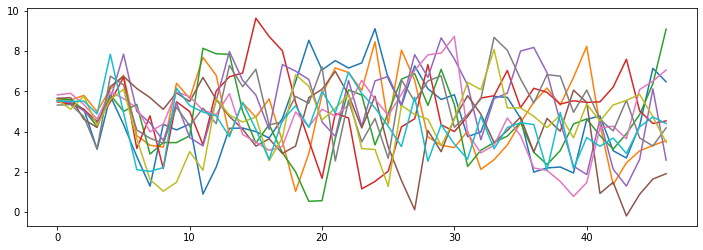

In [12]:
# #==****===========
print(clim_u.shape)
data = clim_u
clim_u_test=data[:,:,30,30]

fig = plt.figure(figsize=(12,4),facecolor='none')
# plt.plot(np.arange(0,47),clim_u_test[1,:])
for ii in range(0,10):
     plt.plot(np.arange(0,47),clim_u_test[:,ii])



In [13]:
# clusters defined by success and sign:

# index_POS_success=[ 1, 2,  3,  4,  5,  8,  9, 13]
# index_POS_unsuccess=[11, 12]
# index_NEG_success=[6]
# index_NEG_unsuccess=[ 0,  7, 10]

index_all_pos=[1,  2,  3,  4,  5,  8,  9, 11, 12, 13] # only positive responses!
tseries_model_es_only_pos = tseries_model_es[:,:,:,:,index_all_pos] # only positive responses!
print(tseries_model_es_only_pos.shape)

tseries_model_es_reshaped=np.transpose(tseries_model_es_only_pos,(1,0,4,2,3))
tseries_model_es_reshaped_members = np.reshape(tseries_model_es_reshaped,(28,-1,181,360))

tseries_model_es_reshaped_members.shape

# load file to array
index_Zpos = np.load('index_NEG_success_mem.npy')
index_Zneg = np.load('index_NEG_unsuccess_mem.npy')


(28, 10, 181, 360, 10)


(28, 100, 181, 360)


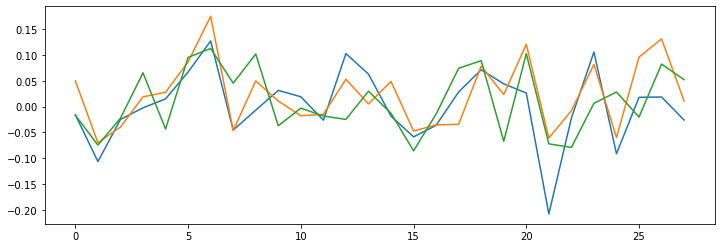

In [15]:

data = tseries_model_es_reshaped_members
print(data.shape)
clim_u_test=data[:,:,30,30]/100

fig = plt.figure(figsize=(12,4),facecolor='none')
# h=plt.plot(np.arange(0,28),clim_u_test[:,(0,14,28)])
h=plt.plot(np.arange(0,28),clim_u_test[:,(0,10,20)])


In [16]:
tseries_model_es_em=np.mean(tseries_model_es,axis=0)

tseries_model_es_POS_success=tseries_model_es_reshaped_members[:,index_Zpos,:,:]
tseries_model_es_POS_unsuccess=tseries_model_es_reshaped_members[:,index_Zneg,:,:]

# choose time lag?
t28=range(0,28)
# t=range(0,5)
tseries_model_es_POS_success_lag0to28=np.mean(np.mean(tseries_model_es_POS_success[t28,:,:,:],axis=0),axis=0)                                    
tseries_model_es_POS_unsuccess_lag0to28=np.mean(np.mean(tseries_model_es_POS_unsuccess[t28,:,:,:],axis=0),axis=0)
                                   
# w1
tw1=range(0,7)
tseries_model_es_POS_success_w1=np.mean(np.mean(tseries_model_es_POS_success[tw1,:,:,:],axis=0),axis=0)
tseries_model_es_POS_unsuccess_w1=np.mean(np.mean(tseries_model_es_POS_unsuccess[tw1,:,:,:],axis=0),axis=0)

# w2
tw2=range(8,14)
tseries_model_es_POS_success_w2=np.mean(np.mean(tseries_model_es_POS_success[tw2,:,:,:],axis=0),axis=0)
tseries_model_es_POS_unsuccess_w2=np.mean(np.mean(tseries_model_es_POS_unsuccess[tw2,:,:,:],axis=0),axis=0)

# w2
tw3=range(15,21)
tseries_model_es_POS_success_w3=np.mean(np.mean(tseries_model_es_POS_success[tw3,:,:,:],axis=0),axis=0)
tseries_model_es_POS_unsuccess_w3=np.mean(np.mean(tseries_model_es_POS_unsuccess[tw3,:,:,:],axis=0),axis=0)

# w2
tw4=range(22,28)
tseries_model_es_POS_success_w4=np.mean(np.mean(tseries_model_es_POS_success[tw4,:,:,:],axis=0),axis=0)
tseries_model_es_POS_unsuccess_w4=np.mean(np.mean(tseries_model_es_POS_unsuccess[tw4,:,:,:],axis=0),axis=0)


In [17]:
from scipy import stats

# % significance for cyc freq anomalies

# Calculate the T-test for the means of two independent samples of scores.
# This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. 
# This test assumes that the populations have identical variances by default.

# ---------------------------------
# --- POS succ ----------------
X=np.mean(tseries_model_es_POS_success[t28,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_success = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_success[ii,jj]=p    
        
# ---------------------------------
# --- POS unsucc ----------------
X=np.mean(tseries_model_es_POS_unsuccess[t28,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_unsuccess = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_unsuccess[ii,jj]=p
        

# --- POS diff ----------------
X=np.mean(tseries_model_es_POS_success[t28,0:15,:,:],axis=0)-np.mean(tseries_model_es_POS_unsuccess[t28,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_diff = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_diff[ii,jj]=p
        


In [18]:
# significance by week

# all   # ---------------------------------
# --- POS succ ----------------
X=np.mean(tseries_model_es_POS_success[tw1,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_success_w1 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_success_w1[ii,jj]=p    
        
# ---------------------------------
# --- POS unsucc ----------------
X=np.mean(tseries_model_es_POS_unsuccess[tw1,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_unsuccess_w1 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_unsuccess_w1[ii,jj]=p
        


        # -------w1--------------------------
# --- POS succ ----------------
X=np.mean(tseries_model_es_POS_success[tw1,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_success_w1 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_success_w1[ii,jj]=p    
        
# ---------------------------------
# --- POS unsucc ----------------
X=np.mean(tseries_model_es_POS_unsuccess[tw1,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_unsuccess_w1 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_unsuccess_w1[ii,jj]=p
        
        
        # ------------w2---------------------
# --- POS succ ----------------
X=np.mean(tseries_model_es_POS_success[tw2,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_success_w2 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_success_w2[ii,jj]=p    
        
# ---------------------------------
# --- POS unsucc ----------------
X=np.mean(tseries_model_es_POS_unsuccess[tw2,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_unsuccess_w2 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_unsuccess_w2[ii,jj]=p
        
        
        # ----------w3-----------------------
# --- POS succ ----------------
X=np.mean(tseries_model_es_POS_success[tw3,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_success_w3 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_success_w3[ii,jj]=p    
        
# ---------------------------------
# --- POS unsucc ----------------
X=np.mean(tseries_model_es_POS_unsuccess[tw3,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_unsuccess_w3 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_unsuccess_w3[ii,jj]=p
        

        
# ----------w4-----------------------
# --- POS succ ----------------
X=np.mean(tseries_model_es_POS_success[tw4,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_success_w4 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_success_w4[ii,jj]=p    
        
# ---------------------------------
# --- POS unsucc ----------------
X=np.mean(tseries_model_es_POS_unsuccess[tw4,:,:,:],axis=0)
X=np.transpose(X,(1,2,0))
yy,tt,ll = X.shape
p_array_cyc_model_POS_unsuccess_w4 = np.zeros((yy,tt))

for ii in np.arange(0,yy,1):
    for jj in np.arange(0,tt,1):
        ttest_result, p = stats.ttest_ind(X[ii,jj,:], 0*X[ii,jj,:])
        p_array_cyc_model_POS_unsuccess_w4[ii,jj]=p
        

/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


Figure(refwidth=2.5)

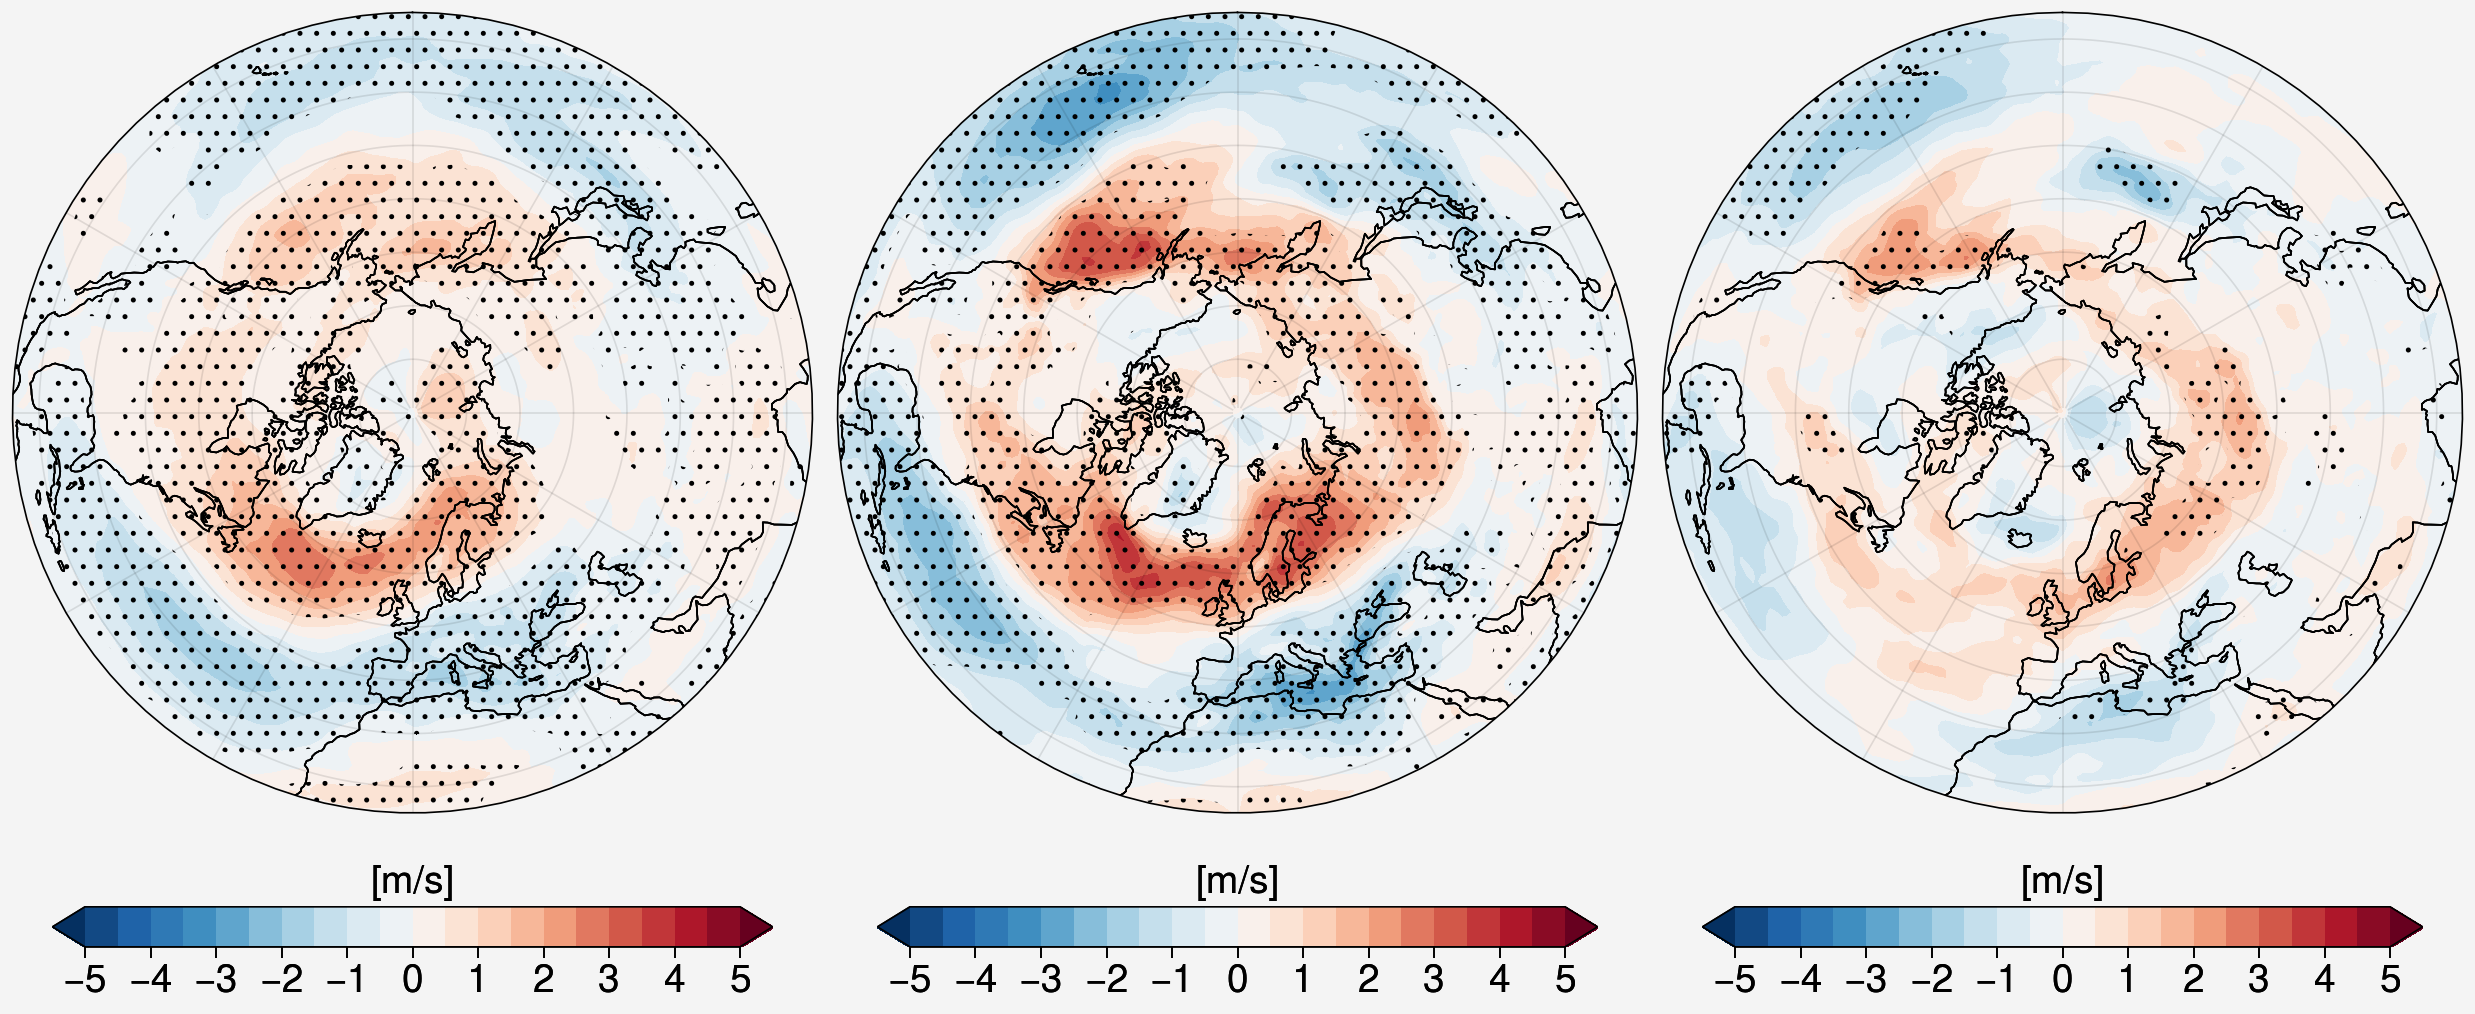

In [21]:
import proplot as pplt


fig = pplt.figure(facecolor='none')
fig,axs = pplt.subplots(ncols=3, nrows=1, proj='npaeqd',panelpad='2em',axwidth=4)

color = 'RdBu_r' # The color of the filled contours, there are many options, so get creative!
# color = 'bwr_r'
colorbarMin=-2.5
colorbarMax=2.5
colorspace=0.5
clevel_p0 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=-5
colorbarMax=5
colorspace=0.5
clevel_p1 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=5
colorbarMax=100
colorspace=5
clevel2 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

# set hatching for each level
hatches =  ['', '..']
p_levels = [0.0, 0.1]
globe=True

# ====sub0=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_success_lag0to28, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_success, coord=longitude)

m = axs[0].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[0].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[0].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      
    
    
# ====sub1=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_unsuccess_lag0to28, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_unsuccess, coord=longitude)

m = axs[1].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[1].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[1].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
          
    
# ====sub2=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_success_lag0to28-tseries_model_es_POS_unsuccess_lag0to28, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_diff, coord=longitude)

m = axs[2].contourf(cyclic_lons, latitude, -flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[2].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[2].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      
    
savelocation="Figures/"
savefileName='U850_after_spv_cluster_by_succ_POS_memebrs.pdf'
fig.savefig(savelocation+savefileName, format='pdf',bbox_inches = "tight")


/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


Figure(refwidth=2.5)

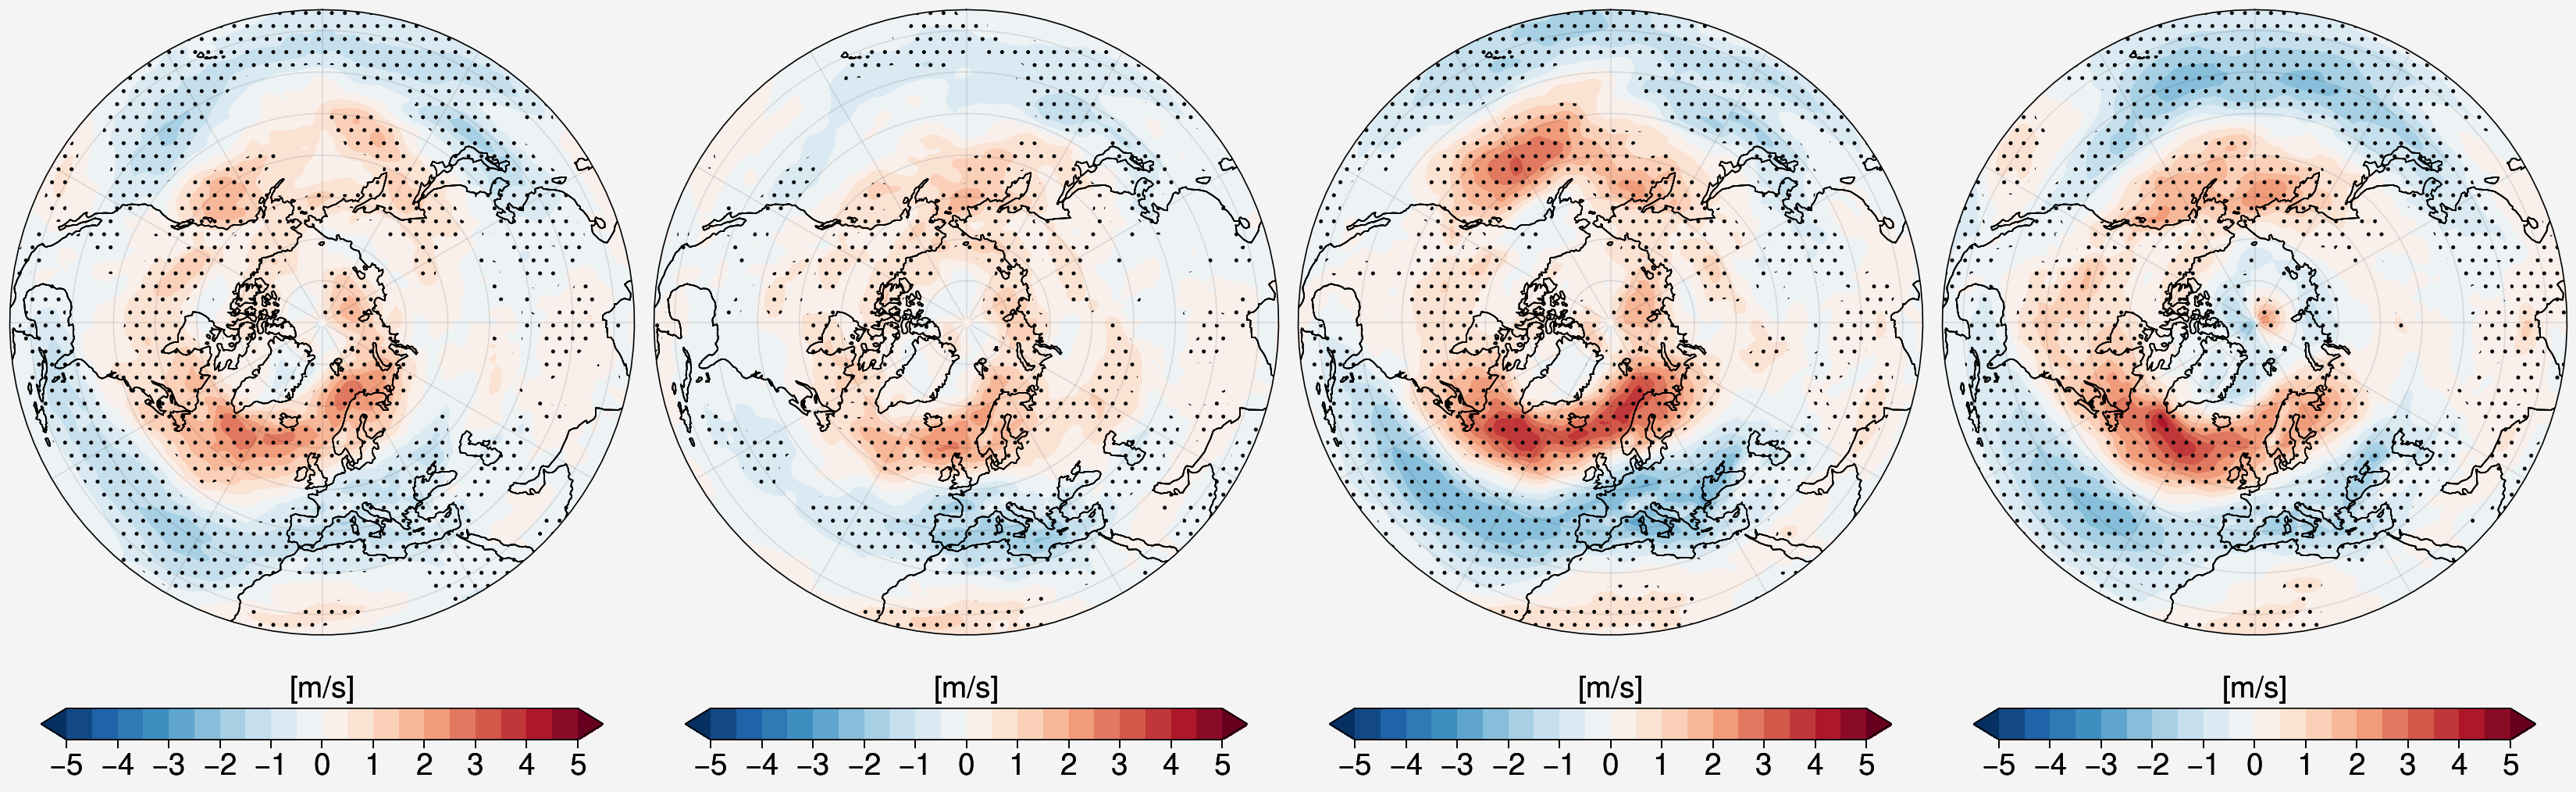

In [22]:
import proplot as pplt


fig = pplt.figure(facecolor='none')
fig,axs = pplt.subplots(ncols=4, nrows=1, proj='npaeqd',panelpad='2em',axwidth=4)

color = 'RdBu_r' # The color of the filled contours, there are many options, so get creative!
# color = 'bwr_r'
colorbarMin=-5
colorbarMax=5
colorspace=1
clevel_p0 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=-5
colorbarMax=5
colorspace=0.5
clevel_p1 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=5
colorbarMax=100
colorspace=5
clevel2 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

# set hatching for each level
hatches =  ['', '..']
p_levels = [0.0, 0.1]
globe=True

# ====sub0=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_success_w1, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_success_w1, coord=longitude)

m = axs[0].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[0].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[0].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      
    
    
# ====sub1=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_success_w2, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_success_w2, coord=longitude)

m = axs[1].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[1].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[1].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
          
    
# ====sub2=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_success_w3, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_success_w3, coord=longitude)

m = axs[2].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[2].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[2].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      

# ====sub3=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_success_w4, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_success_w4, coord=longitude)

m = axs[3].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[3].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[3].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      
    
    
savelocation="Figures/"
savefileName='u850_after_spv_cluster_by_succ_POS_memebrs_successful_with_time.pdf'
fig.savefig(savelocation+savefileName, format='pdf',bbox_inches = "tight")


/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


Figure(refwidth=2.5)

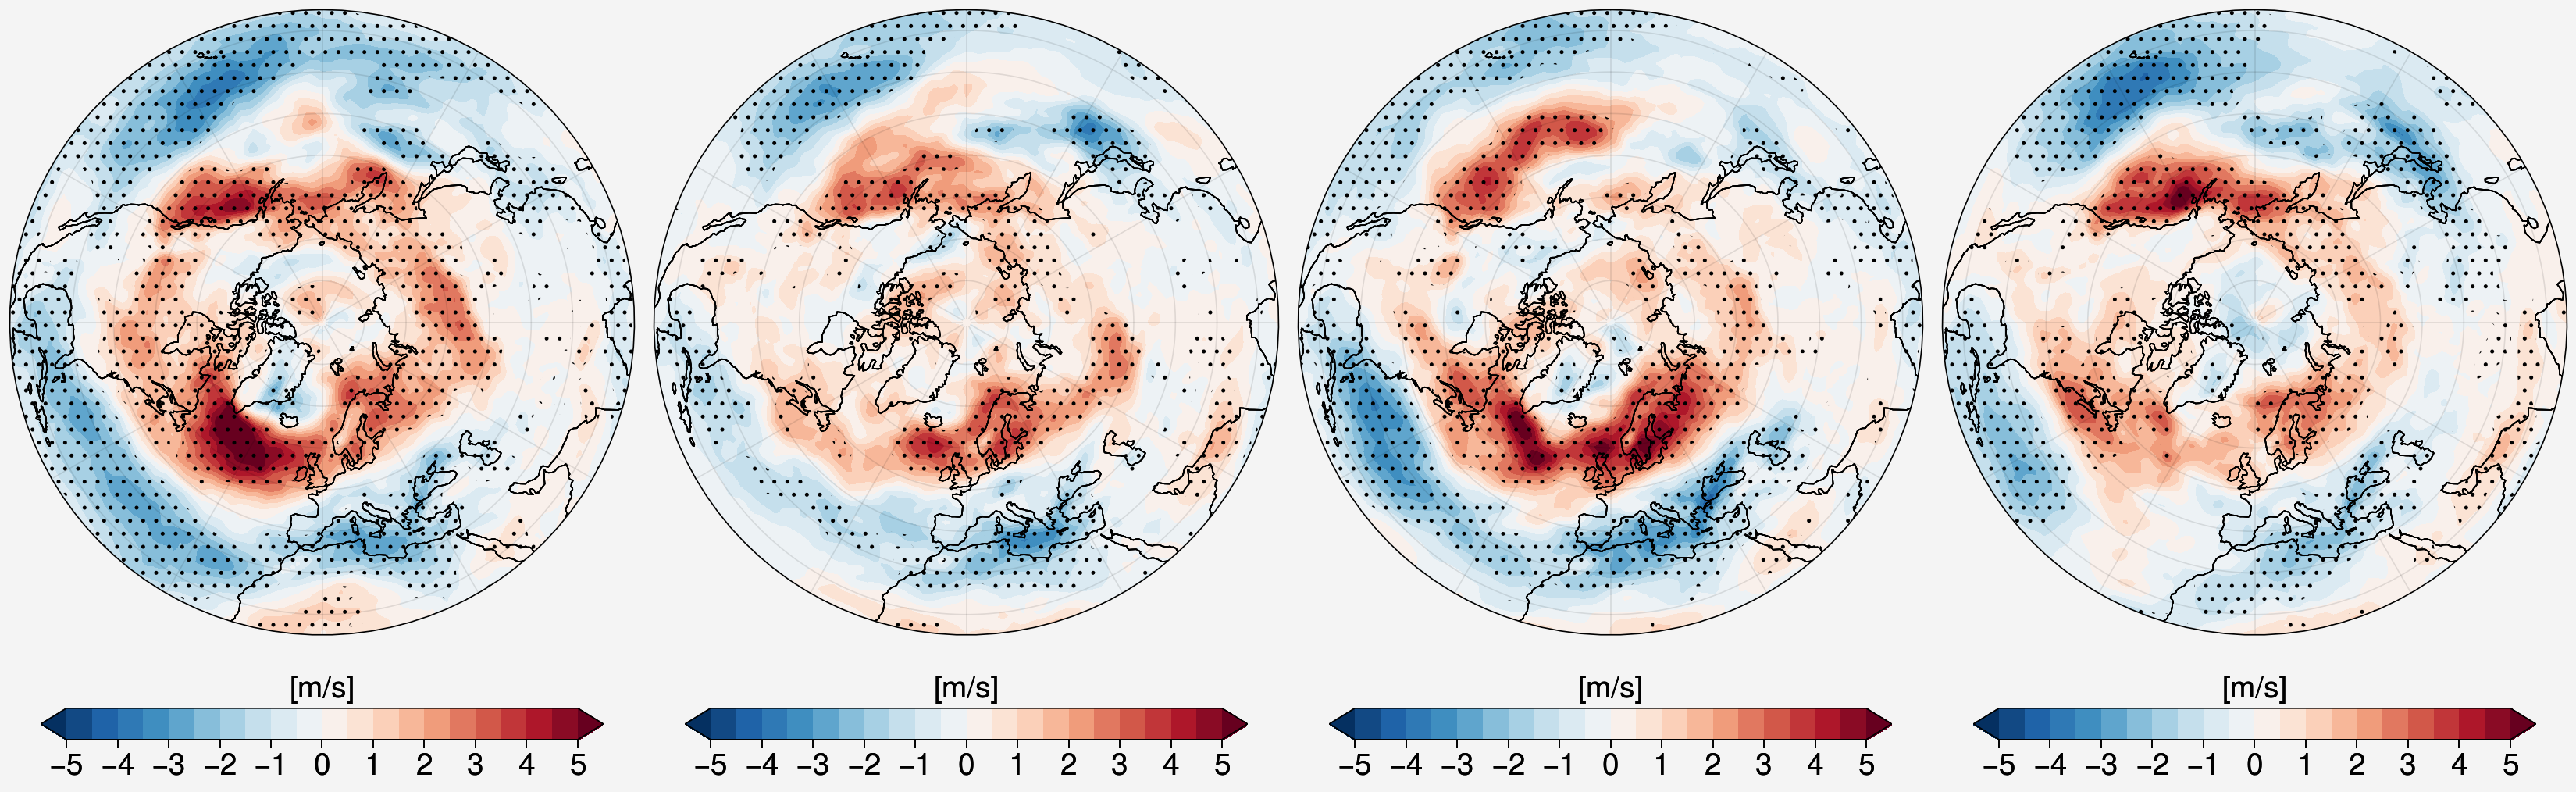

In [26]:
import proplot as pplt


fig = pplt.figure(facecolor='none')
fig,axs = pplt.subplots(ncols=4, nrows=1, proj='npaeqd',panelpad='2em',axwidth=4)

color = 'RdBu_r' # The color of the filled contours, there are many options, so get creative!
# color = 'bwr_r'
colorbarMin=-5
colorbarMax=5
colorspace=1
clevel_p0 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=-5
colorbarMax=5
colorspace=0.5
clevel_p1 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=5
colorbarMax=100
colorspace=5
clevel2 = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

# set hatching for each level
hatches =  ['', '..']
p_levels = [0.0, 0.1]
globe=True

# ====sub0=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_unsuccess_w1, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_unsuccess_w1, coord=longitude)

m = axs[0].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[0].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[0].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      
    
    
# ====sub1=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_unsuccess_w2, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_unsuccess_w2, coord=longitude)

m = axs[1].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[1].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[1].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
          
    
# ====sub2=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_unsuccess_w3, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_unsuccess_w3, coord=longitude)

m = axs[2].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[2].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[2].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      

# ====sub3=====

flag_ensm_anom, cyclic_lons = add_cyclic_point(tseries_model_es_POS_unsuccess_w4, coord=longitude)
# flag_ensm_clim, cyclic_lons = add_cyclic_point(Upast_djf_mmm, coord=longitude)
flag_ensm_stat, cyclic_lons = add_cyclic_point(p_array_cyc_model_POS_unsuccess_w4, coord=longitude)

m = axs[3].contourf(cyclic_lons, latitude, flag_ensm_anom, levels=clevel_p1, cmap=color, globe=globe, extend='both')
m3 = axs[3].contourf(cyclic_lons, latitude, flag_ensm_stat, levels=p_levels, hatches=hatches,
                   colors='none',extend='both')

cbar=axs[3].colorbar(m, loc='b',length=0.9, span=1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(label='[m/s]',fontsize=14)
fig.format(coast=True, lonlines=30, boundinglat=15)
      
    
    
savelocation="Figures/"
savefileName='u850_after_spv_cluster_by_succ_POS_memebrs_unsuccessful_with_time.pdf'
fig.savefig(savelocation+savefileName, format='pdf',bbox_inches = "tight")
